# 0. Initial set up

In [1]:
import os
import sys
import warnings
from SOBER._utils import TensorManager
tm = TensorManager()
sys.path.append(os.path.join(os.getcwd(), '..'))
warnings.filterwarnings('ignore')

# 1. Set up the problem.
## 1.1 define the domain, bounds

In [2]:
import torch
from sklearn.preprocessing import StandardScaler  # Import StandardScaler


# set bounds
# Assume our bounds are standardised for statistical model.
# e.g. originally SOC [0, 100] but convert to [-2, 3], for better fitting.
bounds = torch.tensor([
    [0, 0], # lower bound 
    [100, 60], # upper bound
]).double()

# set label names
label_names = ["SOC", "Temp"]

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

## 1.2 define the synthetic lifetime function

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import Rbf
import pandas as pd

# def synthetic_lifetime(X):
#     # synthetic lifetime in years.
#     # We assume over 2 years are good one.
#     return (torch.sin(0.15 * torch.pi * X.sum(axis=1))+threshold_lifetime).unsqueeze(-1)

# We set threshold that defines good/bad battery
threshold_lifetime = 8


#Lifetime function from literature
LiftimeJossen = pd.read_json('PriorKnowledge.json')

# Extract data fields
StorageTemperatures = [data['Storage_Temperature'] for data in LiftimeJossen['data']]
UsedStoredSpecificEnergy = [data['Used_Stored_Specific_Energy'] for data in LiftimeJossen['data']]
LifetimeCoefficients = [data['Lifetime_Coefficient'] for data in LiftimeJossen['data']]
max_UsedStoredSpecificEnergy = max(UsedStoredSpecificEnergy)
Lifetime = [lc / (max_UsedStoredSpecificEnergy * 100 / 365) for lc in LifetimeCoefficients]

rbf = Rbf(StorageTemperatures, UsedStoredSpecificEnergy, Lifetime, function='cubic')

def lifetime_function(X):
    X_np = X.detach().cpu().numpy()
    interpolated_values = rbf(X_np[:, 0], X_np[:, 1])
    return(torch.from_numpy(interpolated_values)).unsqueeze(-1)

# visualising parameters
colour_map = 'inferno'
resolution = 200

def get_plotting_domain():
    x = torch.linspace(bounds[0][0], bounds[1][0], resolution)
    y = torch.linspace(bounds[0][1], bounds[1][1], resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[bounds[0][1], bounds[1][1], bounds[0][0], bounds[1][0]],
        interpolation='nearest',
        origin='lower',
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    #fig.colorbar(aximg, cax=cax)
    cbar = plt.colorbar(image, cax=cax)
    ax.set_xlabel(label_names[1])
    ax.set_ylabel(label_names[0])
    
def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="violet")

def plot_gold(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="gold")

def plot_red(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="o", color="r")

# 2. Set up a Gaussian Process model

In [ ]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

def setting_GP_model(X, Y):
    model = SingleTaskGP(X, Y) # setting GP model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll) # optimize GP hyperparameters
    return model

# def prediction(model, X):
#     posterior = model.posterior(X)
#     prob = torch.distributions.Normal(0,1).cdf(posterior.mean.squeeze() / posterior.stddev)
#     var = prob * (1 - prob) # Bernoulli likelihood
#     return prob, var, posterior.stddev

def prediction(model, X):#,X_mean,X_std,Y_mean,Y_std):
    # Standardize X using the computed mean and std
    X_standardized = torch.tensor(X_scaler.transform(X), dtype=torch.double)
    
    posterior = model.posterior(X_standardized)
    mean = posterior.mean.squeeze()
    std = posterior.variance.sqrt().squeeze()

    # Compute the standardized threshold (assuming threshold_lifetime is your threshold)
    threshold = torch.tensor((0 - Y_scaler.mean_) / Y_scaler.scale_, dtype=torch.double)

    # Calculate probability using the standardized mean and std
    prob = 1 - torch.distributions.Normal(mean, std).cdf(threshold)

    # Variance for Bernoulli likelihood
    var = prob * (1 - prob)
    return prob, var, std

## 2.1 generate the initial dataset.

In [ ]:
seed = 2024
n_initial = 15
torch.random.manual_seed(seed)

X = prior.sample(n_initial)
Y = lifetime_function(X) - threshold_lifetime

X_scaler = StandardScaler()
Y_scaler = StandardScaler()

X_standardized = torch.tensor(X_scaler.fit_transform(X), dtype=torch.double)
Y_normalized = torch.tensor(Y_scaler.fit_transform(Y), dtype=torch.double)



model = setting_GP_model(X_standardized, Y_normalized)

## 2.2 visualise the estimation results

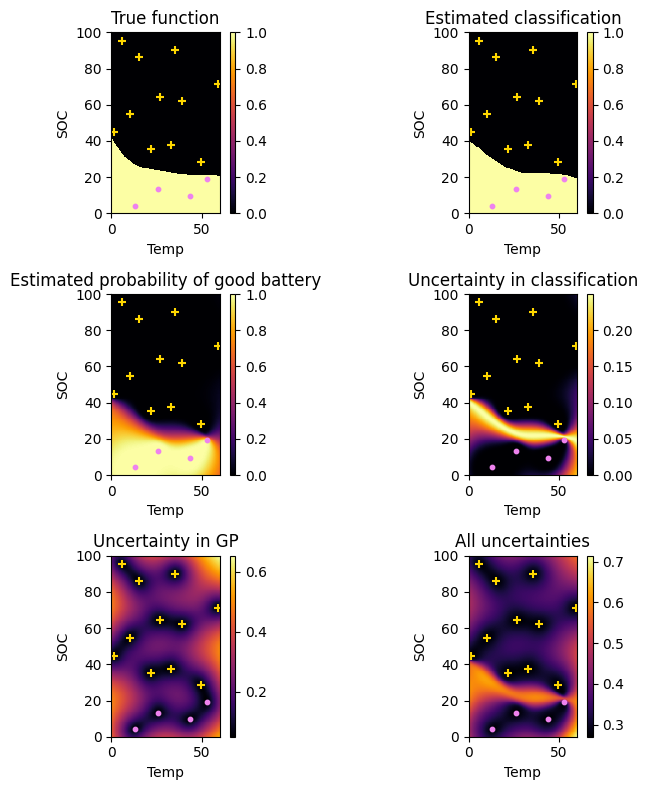

In [6]:
def visualize_model(X, Y, model, X_new=None,):
    n_rows = 3
    n_cols = 2
    fig, axes = plt.subplots(n_rows,n_cols, tight_layout=True, figsize=(8,8))

    Xgrid = get_plotting_domain()

    Ygrid = lifetime_function(Xgrid) - threshold_lifetime
    
    plot_function(Ygrid>0, axes[0,0])
    plot_white(X[Y.squeeze() > 0], axes[0,0])
    plot_gold(X[Y.squeeze() < 0], axes[0,0])
    axes[0,0].set_title("True function")

    prob, var, stddev = prediction(model, Xgrid)#, X_mean, X_std, Y_mean, Y_std)

    #mean_original = mean * Y_std + Y_mean

    plot_function(prob > 0.5, axes[0,1])
    plot_white(X[Y.squeeze() > 0], axes[0,1])
    plot_gold(X[Y.squeeze() < 0], axes[0,1])
    axes[0,1].set_title("Estimated classification")

    plot_function(prob, axes[1,0])
    plot_white(X[Y.squeeze() > 0], axes[1,0])
    plot_gold(X[Y.squeeze() < 0], axes[1,0])
    axes[1,0].set_title("Estimated probability of good battery")

    plot_function(var, axes[1,1])
    plot_white(X[Y.squeeze() > 0], axes[1,1])
    plot_gold(X[Y.squeeze() < 0], axes[1,1])
    axes[1,1].set_title("Uncertainty in classification")

    plot_function(stddev, axes[2,0])
    plot_white(X[Y.squeeze() > 0], axes[2,0])
    plot_gold(X[Y.squeeze() < 0], axes[2,0])
    axes[2,0].set_title("Uncertainty in GP")

    plot_function(torch.distributions.Normal(0,1).cdf(stddev).pow(2) + var, axes[2,1])
    plot_white(X[Y.squeeze() > 0], axes[2,1])
    plot_gold(X[Y.squeeze() < 0], axes[2,1])
    axes[2,1].set_title("All uncertainties")

    if X_new is not None:
        for row in range(n_rows):
            for col in range(n_cols):
                plot_red(X_new, axes[row, col])


    plt.show()
    
visualize_model(X, Y, model)

# 3. Sequential Design

In [7]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.utils import t_batch_mode_transform
from botorch.optim import optimize_acqf


class Uncertainty(AnalyticAcquisitionFunction):
    def __init__(self, model):
        AnalyticAcquisitionFunction.__init__(
            self, 
            model=model,
            posterior_transform=None,
        )
        
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X):
        if len(X.shape) > 2:
            X = X.squeeze()
        posterior = self.model.posterior(X)
        mean, stddev = posterior.mean.squeeze(), posterior.stddev
        prob = torch.distributions.Normal(0,1).cdf(mean / stddev)
        var = prob * (1 - prob)
        var_total = torch.distributions.Normal(0,1).cdf(stddev).pow(2) + var
        return var_total
    
def optimize_function(acqf,X_scaler):
    bounds_standardized = torch.tensor(X_scaler.transform(bounds), dtype=torch.double)
    print(bounds_standardized)
    X_next, _ = optimize_acqf(
        acqf,
        bounds=bounds_standardized,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )
    X_next_original_numpy = X_scaler.inverse_transform(X_next.numpy())
    X_next_original = torch.tensor(X_next_original_numpy, dtype=torch.double)
    return X_next_original

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[45.6686, 60.0000]], dtype=torch.float64)
>>>>>> 1-th iteration


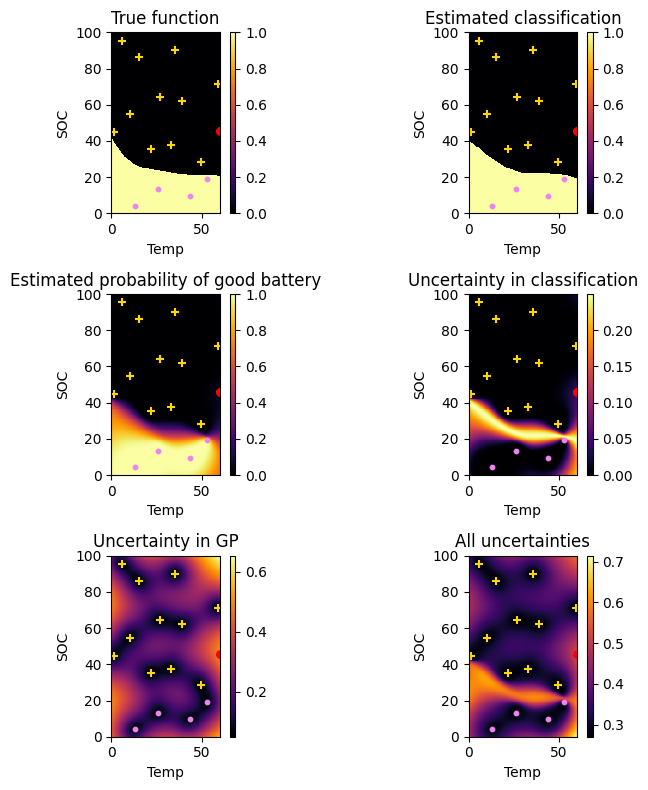

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[100.,  60.]], dtype=torch.float64)
>>>>>> 2-th iteration


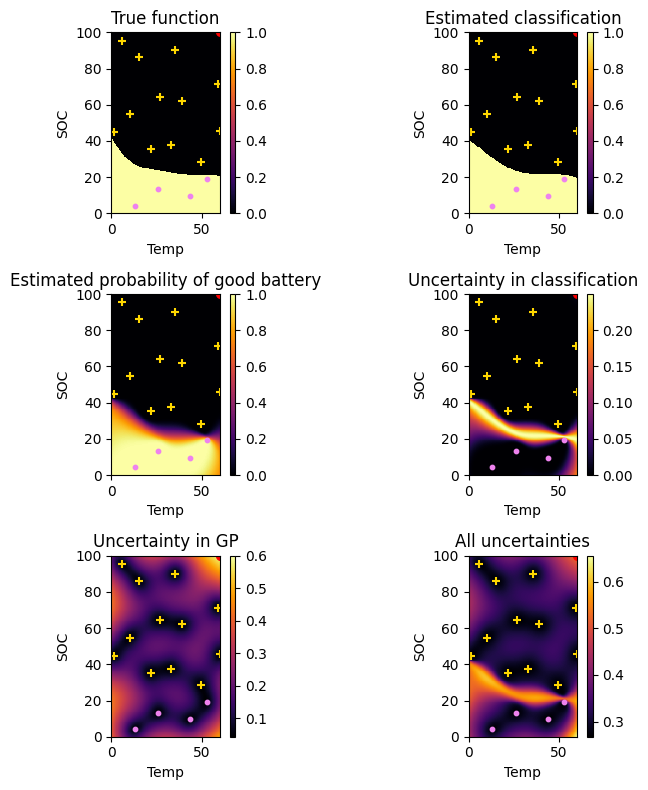

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[54.8751,  0.0000]], dtype=torch.float64)
>>>>>> 3-th iteration


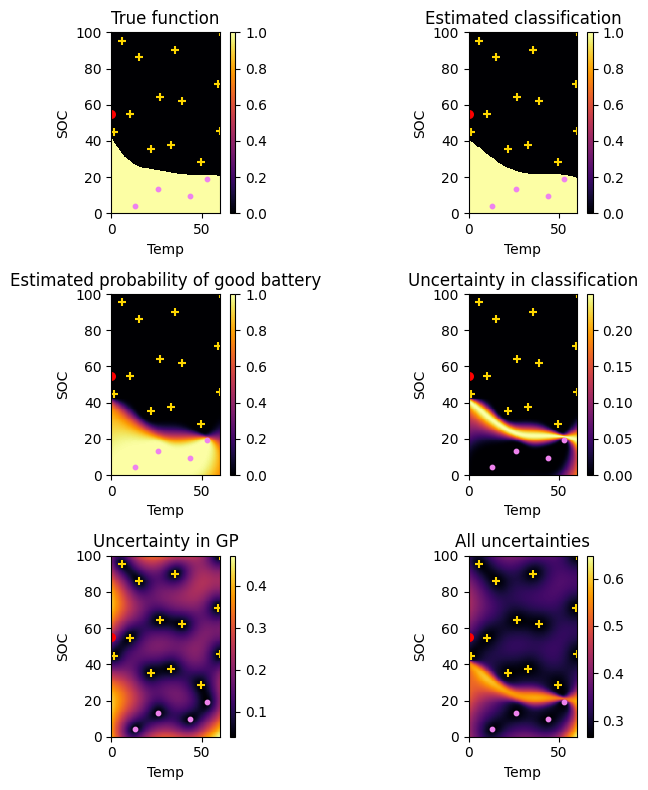

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[41.4353, 46.0022]], dtype=torch.float64)
>>>>>> 4-th iteration


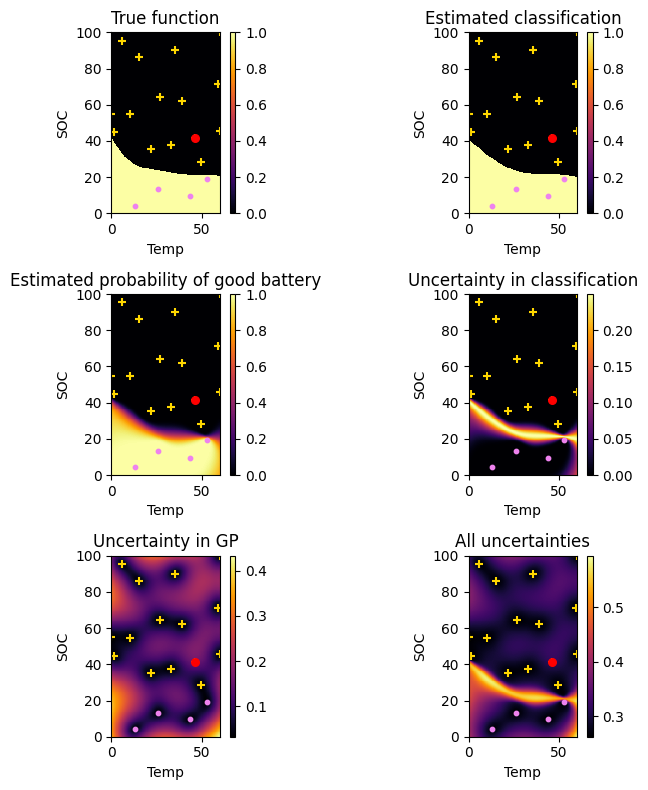

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[43.9421, 16.0592]], dtype=torch.float64)
>>>>>> 5-th iteration


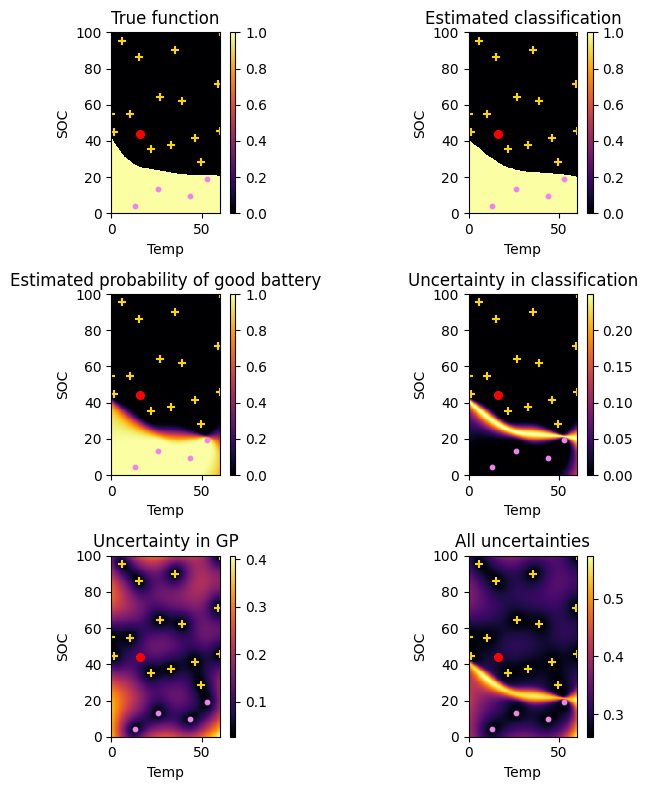

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[39.1904, 55.0775]], dtype=torch.float64)
>>>>>> 6-th iteration


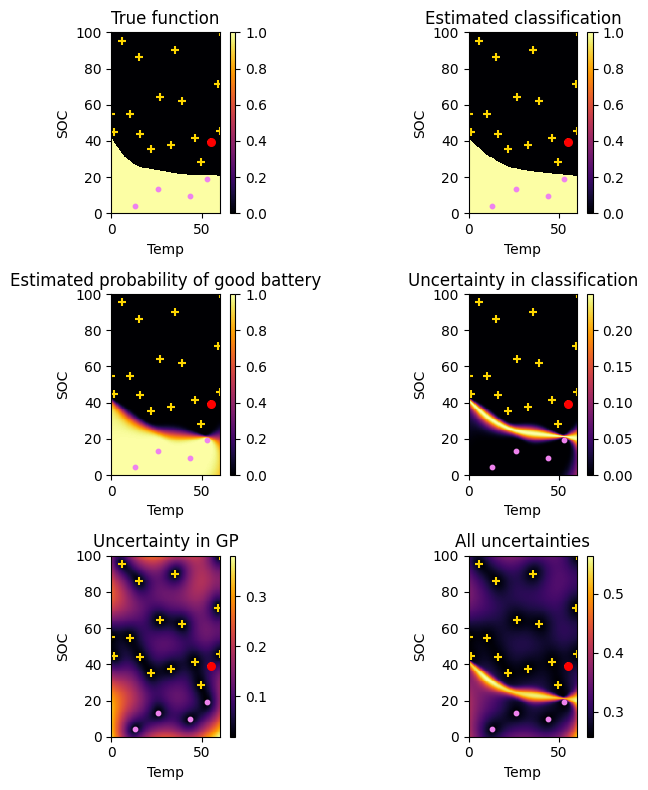

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[41.8522, 26.8190]], dtype=torch.float64)
>>>>>> 7-th iteration


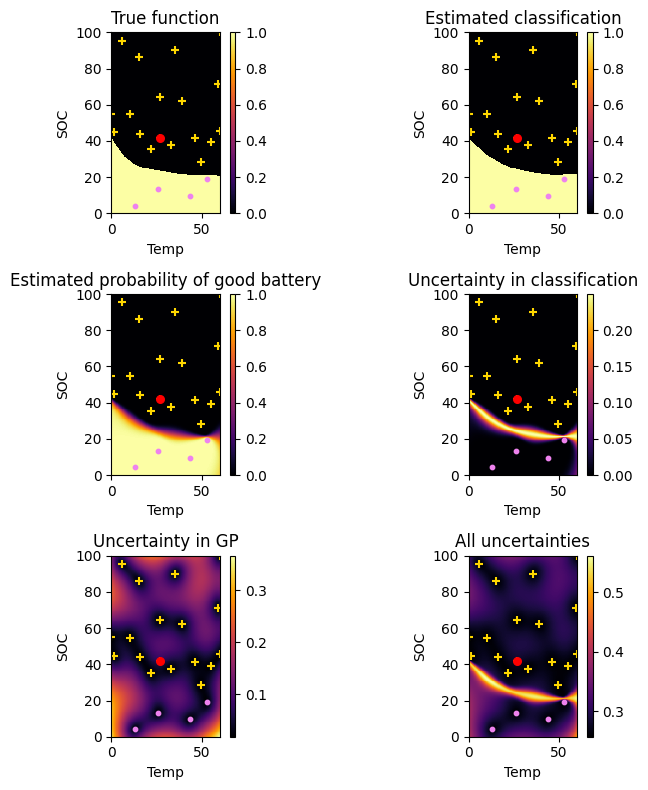

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[47.6871,  8.8864]], dtype=torch.float64)
>>>>>> 8-th iteration


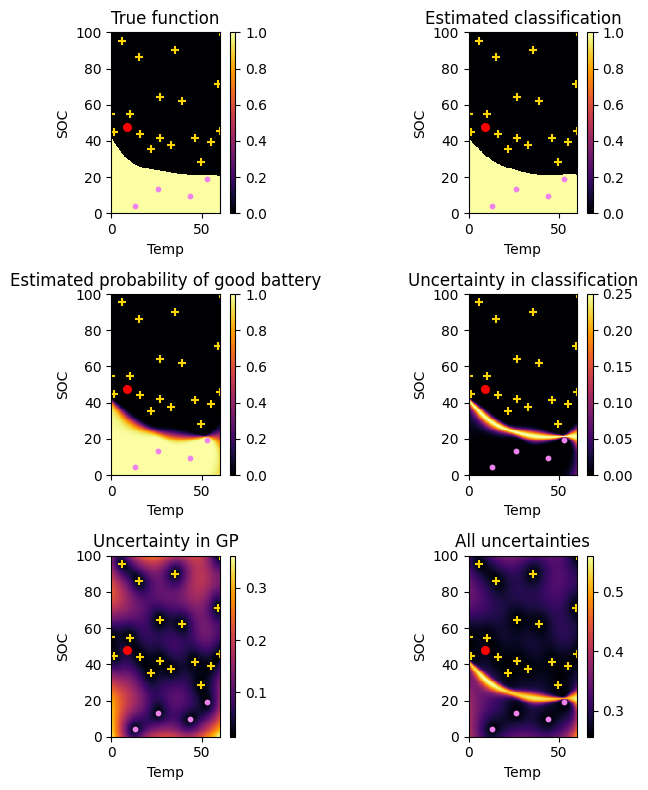

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[42.4955, 33.7825]], dtype=torch.float64)
>>>>>> 9-th iteration


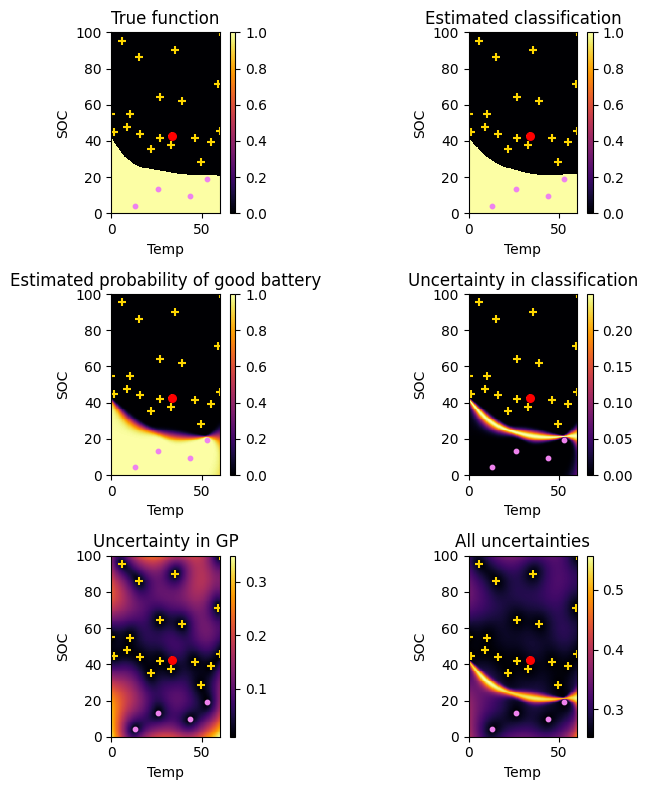

tensor([[-1.6448, -1.6772],
        [ 1.7992,  1.8196]], dtype=torch.float64)
tensor([[37.8980, 40.9076]], dtype=torch.float64)
>>>>>> 10-th iteration


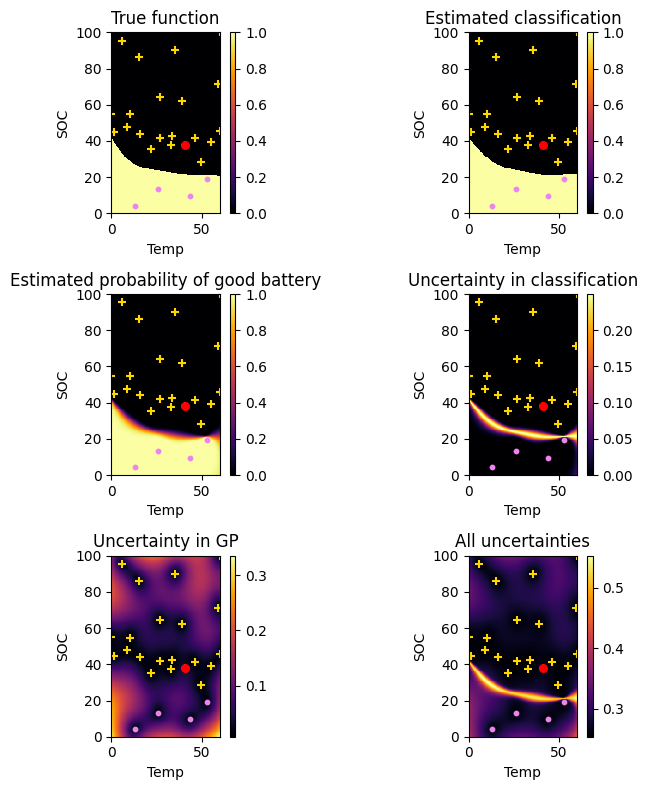

In [ ]:
n_iter = 10

for i in range(n_iter):
    # Compute statistics
    # X_mean = X.mean(dim=0, keepdim=True)
    # X_std = X.std(dim=0, unbiased=False, keepdim=True)
    # Y_mean = Y.mean(dim=0, keepdim=True)
    # Y_std = Y.std(dim=0, unbiased=False, keepdim=True)

    # Standardize and normalize
    # X_standardized = (X - X_mean) / X_std
    # Y_normalized = (Y - Y_mean) / Y_std
    X_standardized = torch.tensor(X_scaler.transform(X), dtype=torch.double)
    Y_normalized = torch.tensor(Y_scaler.transform(Y), dtype=torch.double)

    # Train model
    model = setting_GP_model(X_standardized, Y_normalized)

    #model = setting_GP_model(X, Y)   # update and fit model
    acqf = Uncertainty(model)        # set up selection criteria (acquisition function)
    X_next = optimize_function(acqf,X_scaler) # selecting the next point via optimisaiton
    #print(X_next)

    #print(X_next_original)
    Y_next = lifetime_function(X_next) - threshold_lifetime  # run experiment
    
    # merge results
    X = torch.vstack([X, X_next])
    Y = torch.vstack([Y, Y_next])
    # visualise the results
    print(">>>>>> "+str(i +1)+"-th iteration")
    visualize_model(X, Y, model, X_new=X_next)